# Lab 1 - Gaussian Process Regressor
---

### About me:

Hello World!

I am Tanmay Khandait.

Feel free to reach me at tkhandai@asu.edu

## Setup

In [9]:
import numpy as np
import  matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal, norm
from scipy.stats import norm
import scipy

rng = np.random.default_rng(12345)

## Motivation

So we are given the following points.

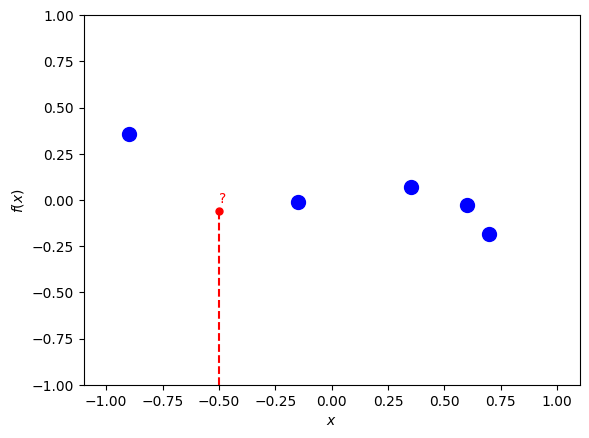

In [10]:
f = lambda x :(1-(3*x**2))*np.sin(np.pi*x) *x**2

x_orig = np.linspace(-1,1,50)
y_orig = f(x_orig)

x = np.array([-0.9,-0.15,0.35, 0.6, 0.7])
y = f(x)

question_pt = -0.5
fig, ax = plt.subplots()

ax.plot(x,y,".b", ms = 20)
ax.vlines(question_pt, -1, f(question_pt), linestyle="--", color = "r")
ax.plot(question_pt, f(question_pt),"r.", ms = 10)
ax.text(question_pt, f(question_pt)+0.05, '?', style='normal', color = "r")

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1,1)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")

plt.show()


1. Can we predict the value and also provide uncertainty estimates?
2. Can we do this with using plain old Gaussian?

## Let's enter the Gaussian World


### Univariate Normal Distribution

*   A random variable X is normally distributed with mean $\mu$ and variance $\sigma^2$ if it has the probability density function of X as:
$$ f(x) = \frac{1}{\sqrt{2 \pi} \sigma} exp{\left(-\frac{{\left(x - \mu \right)}^{2}}{2 \sigma^{2}}\right)}$$

*   In this expression, you see the squared difference between the variable $x$ and its mean, $\mu$.
*   This value will be minimized when $x$ is equal to $\mu$.
*   The quantity $-\frac{{x-\mu}^2}{\sigma^2}$ will take its largest value when $x$ is equal to $\mu$ or likewise since the exponential function is a monotone function, the normal density takes a maximum value when $x$ is equal to $\mu$.
*   The variance $\sigma^2$ defines the spread of the distribution about that maximum. If it is large, then the spread is going to be large, otherwise, if the value is small, then the spread will be small.




If $X$ is random variable that follows a normal distribution with mean $\mu$ and variance $\sigma^2$, then we will denote it as $X \sim \mathcal{N}(\mu, \sigma^2)$.    

    
If you are not familiar, play around with this link: https://demonstrations.wolfram.com/TheNormalDistribution/


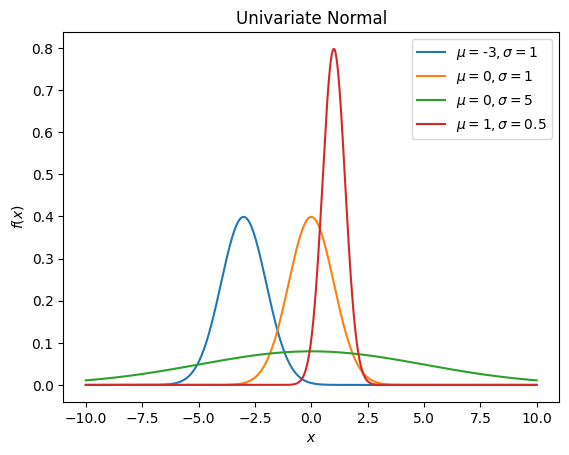

In [11]:
def univariate_density(x, mu, sigma):
    return (2*np.pi*sigma**2)**(-.5) * np.exp(-.5* ((x - mu)/sigma)**2)


x_vals = np.linspace(-10,10, 1000)                          #generate 1000 evenly placed values of x from -10 to 10
params = [(-3,1), (0, 1), (0,5), (1,.5)]                    #Different mean and std dev of gaussian we want to consider
#plot the density for differnet mean and std dev
for mu, sigma in params:
    p_vals = univariate_density(x_vals, mu, sigma)
    plt.plot(x_vals, p_vals, label=r"$\mu=$"+str(mu)+r"$, \sigma=$"+str(sigma))
    
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.legend()
plt.title(r"Univariate Normal")
plt.show()

### The Multivariate Case


The multivariate normal distribution of a k-dimensional random vector  $\mathbf{X} = (X_1, X_2, ..., X_k)^{T}$ is written as $\mathbf{X} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)$.
The probability density function is given as follows:
  $$f(\mathbf{x}) = \frac{1}{{(2\pi)^{k/2}|\Sigma|^{1/2}}}\exp\left(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^{T}\Sigma^{-1}(\mathbf{x}-\mathbf{\mu})\right)$$
  
where, $\mathbf{\mu} = E[\mathbf{X}] = (E[X_1], E[X_2], ..., E[X_k])^{T}$ and $\Sigma_{i,j} = E[(X_i-\mu_i)(X_j-\mu_j)] = Cov[X_i, X_j]$
    

  
*Fun fact: correctly constructed covariance matrices are always symmetric and positive semi-definite. And thus invertible.*

Let us look at the covariance matrix in detail:
$\Sigma_{i,j} = E[(X_i-\mu_i)(X_j-\mu_j)] = Cov[X_i, X_j]$


$$
    \Sigma_{k\times k} = \begin{bmatrix}
        \sigma_1^2          & cov(x_1, x_2)^2       & \ldots    & cov(x_1, x_{k-1})    & cov(x_1, x_k) \\
        cov(x_2, x_1)^2     & \sigma_2^2            & \ldots    & cov(x_2, x_{k-1})    & cov(x_2, x_k) \\
        \vdots              & \vdots                & \ddots    & \vdots                & \vdots \\
        cov(x_{k-1}, x_1)^2 & cov(x_{k-1}, x_2)^2   & \ldots    & \sigma_{k-1}^2        & cov(x_{k-1}, x_k)^2\\
        cov(x_k, x_1)^2     & cov(x_k, x_2)^2       & \ldots    & cov(x_k, x_{k-1})^2   & \sigma_k^2\\
    \end{bmatrix}
$$

The diagonal elements of the matrix contain the variances of the variables.

The off-diagonal elements contain the covariance between all possible pairs of variables.

    
Let us look at a bivariate Gaussian Distribution for different values of the covariance matrix.

In [12]:
def generate_matrices_for_2d_contours(mean, sigma, num_points, rng):
    # Sample points from the distribution. Using linearly spaced points makes the plot cleaner, but you could try sampling from a normal distribution
    y1 =  np.linspace(mean[0] + (-3*sigma[0,0]), mean[0] + (3*sigma[0,0]), num = num_points)
    y2 =  np.linspace(mean[1] + (-3*sigma[1,1]), mean[1] + (3*sigma[1,1]), num = num_points)
    Y1, Y2 = np.meshgrid(y1, y2)

    Y = np.vstack([Y1.reshape(-1), Y2.reshape(-1)])

    # Get the PDF value for samples
    multivariate_pdf = np.array([multivariate_normal.pdf(y, cov=sigma, mean=mean) for y in Y.T])
    multivariate_pdf_reshaped = multivariate_pdf.reshape(num_points, num_points)

    return Y1, Y2, multivariate_pdf_reshaped

In [13]:
def plot_2d_contours(Y1, Y2, p):
  # Plotter Function
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.contourf(Y1, Y2, p, cmap='viridis')
    ax.set_aspect("equal")
    ax.set_xlim(Y1.min(), Y1.max())
    ax.set_ylim(Y2.min(), Y2.max())
    ax.set_xlabel(r"$X_1$")
    ax.set_ylabel(r"$X_2$")
    plt.show()

Define the Mean and Covariaince matrix.

Feel free to play around.

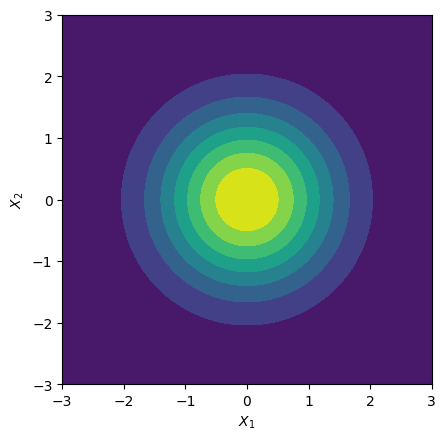

In [14]:
mean = [0,0]
sigma = np.array([[1,0], [0, 1]])
X1, X2, p = generate_matrices_for_2d_contours(mean, sigma = sigma, num_points = 100, rng = rng)
plot_2d_contours(X1, X2, p)

## Marginalization

Given a multivariate distribution, can we compute the pdf of a single variable? - Yes

$f(X_1) = \int{f(X_1, X_2) dX_2}$


Every random variables $X_i \in \mathbf{X}$ has the following distribution: $X_i \sim \mathcal{N}(\mu_i, \Sigma_{i,i})$

Feel free to play around with mean and covariance.


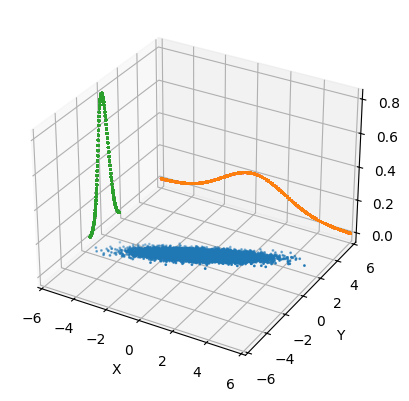

In [15]:
mean = [0,0]
sigma = np.array([[2,0.9], [0.9, 0.5]])

num_points = 100

mvn_object = multivariate_normal(cov=sigma, mean=[0, 0])
y_plot = mvn_object.rvs(num_points**2)
y1_plot = y_plot[:,0]
y2_plot = y_plot[:,1]

y1 =  np.linspace(mean[0] + (-3*sigma[0,0]), mean[0] + (3*sigma[0,0]), num = num_points)
y2 =  np.linspace(mean[1] + (-3*sigma[1,1]), mean[1] + (3*sigma[1,1]), num = num_points)
Y1, Y2 = np.meshgrid(y1, y2)

Y = np.vstack([Y1.reshape(-1), Y2.reshape(-1)])

pdf_y1 = np.array([norm.pdf(y, scale=sigma[0,0], loc=mean[0]) for y in Y[0,:]])
pdf_y1_reshaped = pdf_y1.reshape(num_points, num_points)

pdf_y2 = np.array([norm.pdf(y, scale=sigma[1,1], loc=mean[1]) for y in Y[1,:]])
pdf_y2_reshaped = pdf_y2.reshape(num_points, num_points)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(y1_plot, y2_plot, np.zeros(y2_plot.shape), s=1)
ax.scatter(Y1, 6*np.ones((num_points, num_points)), pdf_y1_reshaped, s=1)
ax.scatter(-6*np.ones((num_points, num_points)), Y2, pdf_y2_reshaped, s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
plt.show()


## Conditioning

If some random variables from the set were fixed, what is the PDF? \\

Or formally, $f(X_i|X_j=x) = ?$

In fact, it is a Gaussian. Or formally, $X_i|(X_j=x) \sim \mathcal{N}(\mu_{*}, \Sigma_{*})$.

In a bivariate case, $f(X_2|X_1=x_1) \propto \exp(-\frac{1}{2}(x_2-\mu_{*})\Sigma_{*}^{-1}(x_2-\mu_{*}))$.

We will see what $\mu_{*}$ and $\Sigma_{*}$ looks like in a few slides.

In [16]:
def plot_3d_contours(Y1, Y2, p):
    # Function to generate 3d plots for conditioning
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(Y1, Y2, p, rstride=2, cstride=2, alpha=0.4, cmap=cm.coolwarm)

    x1_cut = 0.8
    x2_p = np.linspace(-3.1, 3.1, 100)
    z_p = np.linspace(0, p.max()*0.8, 100)
    X2_p, Z_p = np.meshgrid(x2_p, z_p)

    ax.plot_surface(x1_cut, X2_p, Z_p, color='silver', alpha=0.5, zorder=5)

    ax.set_xlabel(R'$X_1$', fontsize=14)
    ax.set_ylabel(R'$X_2$', fontsize=14)

    ax.axes.zaxis.set_ticks([])


    tol = 1e-4
    idx_x_p = (np.where(Y2 < x1_cut+tol) and np.where(Y2 > x1_cut-tol))[0][0]

    x1_c, x2_c, z_c = Y2[idx_x_p], Y1[idx_x_p], p[idx_x_p]

    ax.plot(x1_c, x2_c, z_c, zorder=10)

    plt.show()

Feel free to play around with the mean and the covariance function.

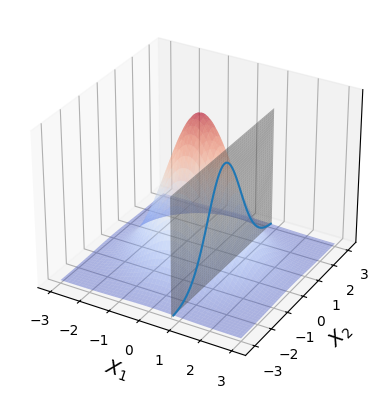

In [17]:
mean = [0,0]
sigma = np.array([[1,0.0], [0.0, 1]])

Y1, Y2, p = generate_matrices_for_2d_contours(mean, sigma = sigma, num_points = 100, rng = rng)
plot_3d_contours(Y1, Y2, p)

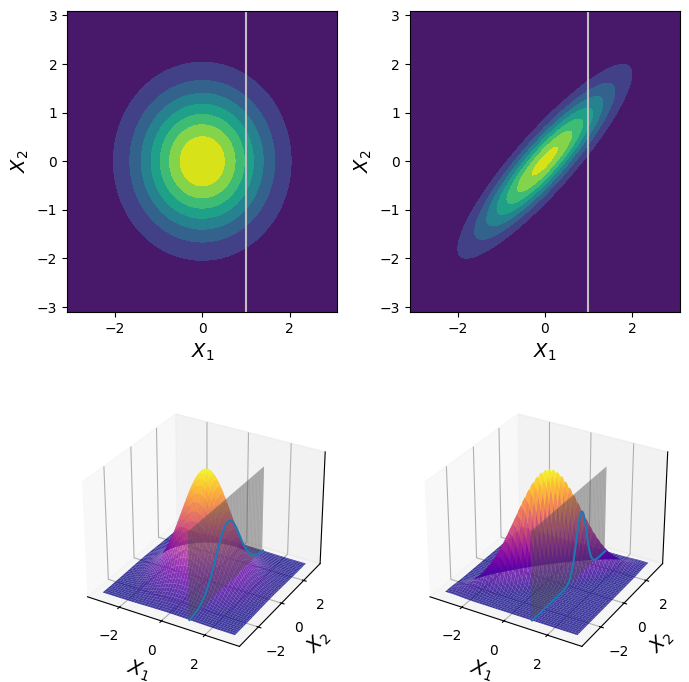

In [18]:
def plot_pdf(fig, subplot, X1, X2, cov):

    # 2X2 covariance matrix for the bivariate Gaussian distribution
    cov_matrix = np.array([[1, cov], [cov, 1]])
    distr = multivariate_normal(cov=cov_matrix, mean=[0, 0], seed=12345)
    # generate PDF of the multivariate Gaussian distribution
    pdf = np.zeros(X1.shape)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            pdf[i,j] = distr.pdf([X1[i,j], X2[i,j]])

    x1_cut = 1

    ax_contour = fig.add_subplot(subplot)
    ax_contour.contourf(X1, X2, pdf)
    ax_contour.plot([x1_cut, x1_cut], [-3.1, 3.1], color='silver')
    ax_contour.set_xlabel(R'$X_1$', fontsize=14)
    ax_contour.set_ylabel(R'$X_2$', fontsize=14)


    ax_pdf = fig.add_subplot(subplot+2, projection = '3d')
    ax_pdf.plot_surface(X1, X2, pdf, cmap='plasma', alpha=0.8, zorder=0)

    # create plane

    x2_p = np.linspace(-3.1, 3.1, 100)
    z_p = np.linspace(0, pdf.max()*0.8, 100)
    X2_p, Z_p = np.meshgrid(x2_p, z_p)
    # plot plane
    ax_pdf.plot_surface(x1_cut, X2_p, Z_p, color='silver', alpha=0.5, zorder=5)

    ax_pdf.set_xlabel(R'$X_1$', fontsize=14)
    ax_pdf.set_ylabel(R'$X_2$', fontsize=14)
    ax_pdf.axes.zaxis.set_ticks([])

    # find the closest idx values of X mesh to x1_cut
    tol = 1e-4
    idx_x_p = (np.where(X2 < x1_cut+tol) and np.where(X2 > x1_cut-tol))[0][0]
    # Select the corresponding values of X, Y, Z (carefully switch X and Y)
    x1_c, x2_c, z_c = X2[idx_x_p], X1[idx_x_p], pdf[idx_x_p]
    # plot line
    ax_pdf.plot(x1_c, x2_c, z_c, zorder=10)

fig = plt.figure(figsize=(7,7))

X1, X2 = np.meshgrid(np.linspace(-3.1, 3.1, num=100),
                     np.linspace(-3.1, 3.1, num=100))

plot_pdf(fig, 221, X1, X2, cov=0)
plot_pdf(fig, 222, X1, X2, cov=0.9)

plt.tight_layout()
plt.show()

## Intuition Setup

Let us sample two random variables $X_1 \sim \mathcal{N}(0,1)$ and $X_2\sim \mathcal{N}(0,1)$.

Next, we can plot multiple independent Gaussian in the coordinates. For example, put vector $X_1$ at $x=-1$ and another vector $X_2$ at $x=1$.

Let's connect points of $X_1$ and $X_2$ by lines. For now, we only generate 20 random points, and then join them up as 10 lines. Keep in mind, that these randomly generated 10 points are Gaussian.

You can control them by varying $num\_points$ and $num\_samples$.

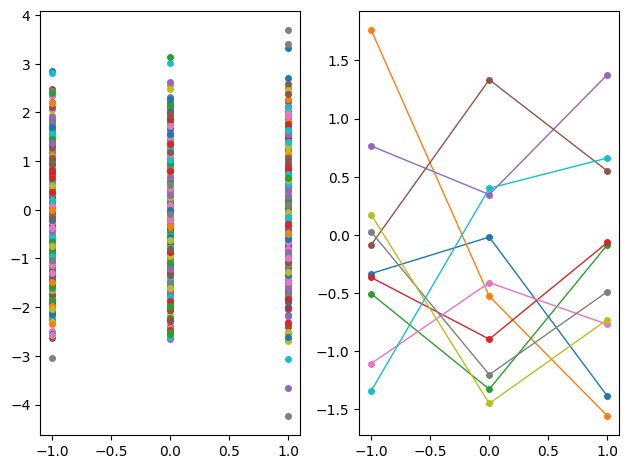

In [19]:
num_points = 3
num_samples = 10

fig, ax = plt.subplots(nrows = 1, ncols = 2)

X = np.linspace(-1, 1, num_points).reshape(-1,1)
f_random = np.random.normal(size=(num_points, 1000))

X_lines = np.linspace(-1, 1, num_points).reshape(-1,1)
f_random_lines = np.random.normal(size=(num_points, num_samples))

ax[0].plot(X, f_random, 'o', linewidth=1, markersize=3, markeredgewidth=2)
ax[1].plot(X_lines, f_random_lines, '-o', linewidth=1, markersize=3, markeredgewidth=2)

fig.tight_layout()

plt.show()

## Revisiting Conditioning

 So what exactly is the mean and variance when there is a conditional multivariate distribution?

$$\mathbf{X} = (X_1, X_2) \sim \mathcal{N}\left(\begin{bmatrix}
    \mathbf{a}\\\mathbf{b}
\end{bmatrix}, \begin{bmatrix}
    A & B\\B^{T} & C
\end{bmatrix}\right)$$

$$X_1|X_2 = \frac{X_1, X_2}{X_2}$$

$$X_1|(X_2 = \mathbf{x}) \sim \mathcal{N}(\mathbf{a} + BC^{-1}(\mathbf{x}-b), A-BC^{-1}B^T)$$

Do you notice the predictive mean is linear in data?

Do you notice that the predictive uncertainty is prior uncertainty minus the reduction in uncertainty?

In [20]:
def generate_conditional_distributions(mean, sigma, fixed_means_dict, num_samples):
    fixed = list(set(list(fixed_means_dict.keys())))
    fixed.sort()
    var = list(set([i for i in range(sigma.shape[0])]).difference(fixed))
    var.sort()
    fixed_means = np.array([[fixed_means_dict[j]] for j in fixed])
    rearrange_array = var + fixed
    def gen_P_matrix(rearrange_array):
        p = np.eye(len(rearrange_array))
        x1 = []
        for j in rearrange_array:
            x1.append(p[j, :])
        return np.array(x1)


    mu_A = np.array([[mean[j] for j in var]]).T
    mu_B = np.array([[mean[j] for j in fixed]]).T
    new_sigma = np.dot(np.dot(gen_P_matrix(rearrange_array), sigma), gen_P_matrix(rearrange_array).T)
    C_AA = new_sigma[:len(var), :len(var)]
    C_AB = new_sigma[:len(var), len(var):]
    C_BB = new_sigma[len(var):, len(var):]
    C_BA = new_sigma[len(var):, :len(var)]

    term_2_mu_A = C_AB @ (np.linalg.inv(C_BB) @ (fixed_means-mu_B))
    if term_2_mu_A.size == 0:
        mu = mu_A
    else:
        mu = mu_A + C_AB @ (np.linalg.inv(C_BB) @ (fixed_means-mu_B))
    cov = C_AA - C_AB@(np.linalg.inv(C_BB)@C_BA)


    samples = {}
    individual_stats = {}
    for i in rearrange_array:
        if i in fixed:
            samples[i] = np.array([fixed_means_dict[i]] * num_samples)
            individual_stats[i] = (fixed_means_dict[i], 0)
        elif i in var:
            samples[i] = rng.normal(mu[var.index(i), 0], cov[var.index(i), var.index(i)], size = (num_samples,))
            individual_stats[i] = (mu[var.index(i), 0], cov[var.index(i), var.index(i)])

    individual_stats_sorted = dict(sorted(individual_stats.items()))
    return mu, cov, samples, individual_stats_sorted

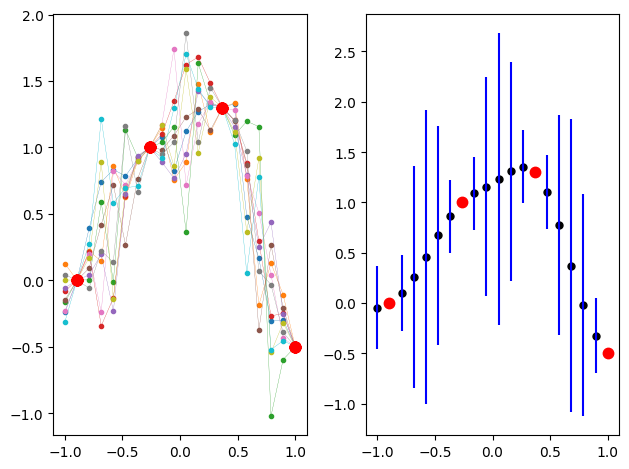

In [21]:
kernel_sigma = 1.1
length_scale = 0.3

def rbf_kernel(kernel_sigma, length_scale, p1,p2):
    return kernel_sigma**2 * (np.exp(-0.5*((p1-p2)**2/length_scale**2)))

N = 20
pts = np.linspace(start = -1, stop = 1, num = N)

cov_20d = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        cov_20d[i,j] = rbf_kernel(kernel_sigma, length_scale, pts[i], pts[j])

mean_20d = [0]*N


fixed_means_dict_20d = {1:0, 7:1, 13:1.3, 19:-0.5}
num_samples = 10
conditional_mean_20d, conditional_cov_20d, samples_20d, var_stats_20d = generate_conditional_distributions(mean_20d, cov_20d, fixed_means_dict_20d, num_samples)

fig = plt.figure()
ax = fig.add_subplot(121)
for i in range(num_samples):
    x = []
    y = []
    for j in range(len(mean_20d)):
        x.append(pts[j])
        y.append(samples_20d[j][i])
    ax.plot(x, y, '.-', linewidth=0.2)

    if len(fixed_means_dict_20d)!=0:
        for i,j  in zip(fixed_means_dict_20d.keys(), fixed_means_dict_20d.values()):
            ax.plot(pts[i],j,"r.", ms = 15)

ax = fig.add_subplot(122)

if len(var_stats_20d)!= 0:
    for index, (i_mean, i_var) in zip(var_stats_20d.keys(), var_stats_20d.values()):
        h = 3*i_var
        ax.plot(pts[index], i_mean, "k.", ms = 10)
        ax.vlines(pts[index], i_mean-h, i_mean+h, colors="b")

    if len(fixed_means_dict_20d)!=0:
        for i,j  in zip(fixed_means_dict_20d.keys(), fixed_means_dict_20d.values()):
            plt.plot(pts[i],j,"r.", ms = 15)

fig.tight_layout()

plt.show()

## Coding up the Gaussian Process Regressor



In [22]:

def rbf_kernel(p1,p2, kernel_length, kernel_sigma, var_noise):
    p1 = p1.flatten()
    p2 = p2.flatten()
    mat = np.zeros((len(p1), len(p2)))

    for i in range(len(p1)):
        for j in range(len(p2)):
            mat[i,j] = kernel_sigma**2 * (np.exp(-0.5*((p1[i]-p2[j])**2/kernel_length**2)))
            # abso = np.abs(p1[i]-p2[j]) / period
            # num = np.sin(np.pi*abso)**2
            # den = length_scale**2
            # mat[i,j] = kernel_sigma**2 * (np.exp(-2*num)/den)
    # print(mat)
    if var_noise == 0:
        return mat
    else:
        return mat + np.diag(rng.normal(0,var_noise, (mat.shape[0],1)))


def GP(X1, y1, X2, kernel_func,  kernel_sigma= 1, kernel_length=1, var_noise = 0):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1),
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1, kernel_length=kernel_length, kernel_sigma = kernel_sigma, var_noise = var_noise)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, kernel_length=kernel_length, kernel_sigma = kernel_sigma, var_noise = 0)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2, kernel_length=kernel_length, kernel_sigma = kernel_sigma, var_noise = 0)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance


In [23]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
func = lambda x :((1-(3*x**2))*np.sin(np.pi*x) *x**2).flatten()
kernel_sigma = 1
length_scale = 0.5
var_noise = 0
# n1 = 8  # Number of points to condition on (training points)
n2 = 1000  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-1, 1)

# Sample observations (X1, y1) on the function
X1 = np.array([-0.9,-0.15,0.35, 0.6, 0.7]).reshape(-1,1)

y1 = func(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, rbf_kernel, kernel_sigma=kernel_sigma, kernel_length=length_scale, var_noise=var_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

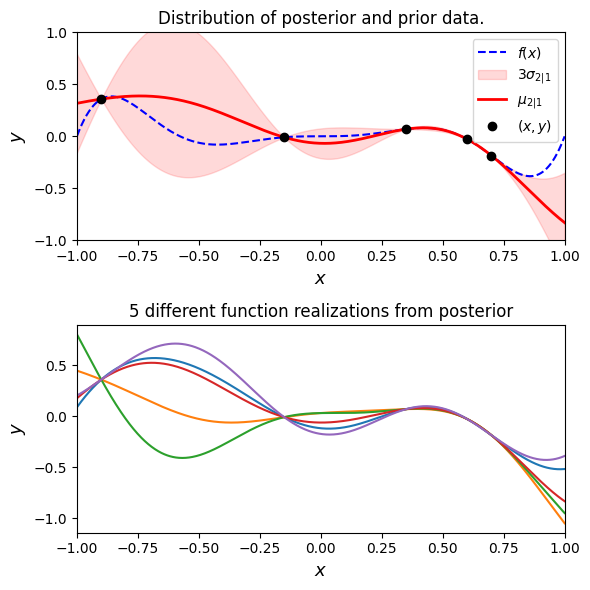

In [24]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, func(X2), 'b--', label='$f(x)$')
ax1.fill_between(X2.flat, μ2-3*σ2, μ2+3*σ2, color='red',
                 alpha=0.15, label='$3 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x, y)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -1, 1])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -1, 1])
ax2.set_xlim([domain[0], domain[1]])
plt.tight_layout()
plt.show()
#

## Tuning the Hyperparameters

In [25]:
from scipy.optimize import minimize

def marglike(par,X,Y):
  # print(par)
  var = 1
  l,sigma_n = par
  n = len(X)

  k = rbf_kernel(X,X, kernel_sigma=var, kernel_length=l, var_noise=sigma_n)

  inverse = np.linalg.inv(k)
  t1 = Y.T @ (inverse @ Y)
  t2 = np.linalg.det(k)
  t3 = 2*np.pi

  # print(t1, t2, t3)
  ml = (1/2)*t1 + (1/2)*np.log(t2) + (n/2)*np.log(t3)
  # print(ml)
  return ml


start = np.array([2,7e-3]) #initial parameters values
print(marglike(start,X1,y1))

re = minimize(marglike,start,args=(X1,y1),method='Nelder-Mead',options={'maxiter':1e4, 'fatol':1e-5, 'disp': True}, bounds  = ((1e-3,1e3), (1e-4,1e-2)))
print(re.message)
print(re.x)

print(marglike(re.x,X1,y1))

8366.774986252773
Maximum number of iterations has been exceeded.
[0.50733594 0.01      ]
1.933944782626491


C:\Users\tanma\AppData\Local\Temp\ipykernel_25112\2395361321.py:25: RuntimeWarning: Maximum number of iterations has been exceeded.
  re = minimize(marglike,start,args=(X1,y1),method='Nelder-Mead',options={'maxiter':1e4, 'fatol':1e-5, 'disp': True}, bounds  = ((1e-3,1e3), (1e-4,1e-2)))


In [ ]:
func = lambda x :((1-(3*x**2))*np.sin(np.pi*x) *x**2).flatten()
kernel_sigma = 1
length_scale = re.x[0]
var_noise = re.x[1]
# n1 = 8  # Number of points to condition on (training points)
n2 = 1000  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-1, 1)

# Sample observations (X1, y1) on the function
X1 = np.array([-0.9,-0.15,0.35, 0.6, 0.7]).reshape(-1,1)

y1 = func(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, rbf_kernel, kernel_sigma=kernel_sigma, kernel_length=length_scale, var_noise=var_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

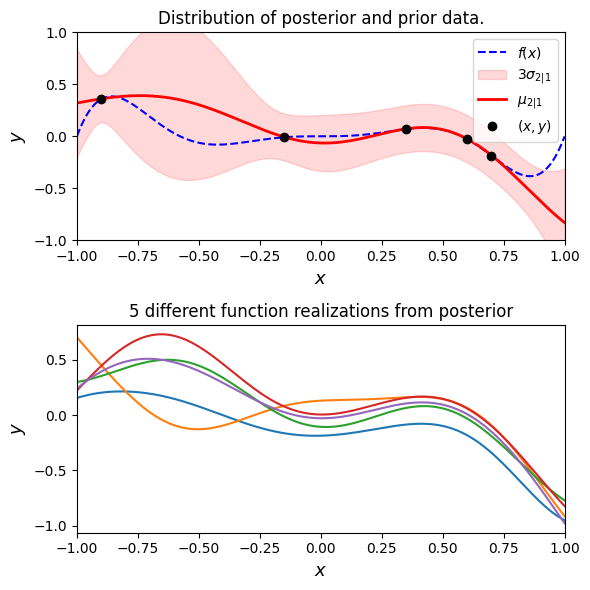

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, func(X2), 'b--', label='$f(x)$')
ax1.fill_between(X2.flat, μ2-3*σ2, μ2+3*σ2, color='red',
                 alpha=0.15, label='$3 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x, y)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -1, 1])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -1, 1])
ax2.set_xlim([domain[0], domain[1]])
plt.tight_layout()
plt.show()